## Step 0: Configure PySpark environment

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1723658114321_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("graphviz", "https://pypi.org/simple")



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [111]:
sc.install_pypi_package("ipython","https://pypi.org/simple")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.feature import Bucketizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Normalizer
import numpy as np
from graphviz import Source

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Step 1: Data Processing and Visualization

In [5]:

data_0 = spark.read.csv('s3://africamining/final_mine_dataset.csv', header=True, inferSchema=True)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
data_1 = spark.read.csv('s3://africamining/final_not_mine_dataset.csv', header=True, inferSchema=True)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
print('Total Columns: %d' % len(data_0.dtypes))
print('Total Rows: %d' % data_0.count())
data_0.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 3
Total Rows: 4560
root
 |-- lable: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

In [10]:
data = spark.read.csv('s3://africamining/combined_output(all_feature).csv', header=True, inferSchema=True)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# 加载数据 (假设数据已经加载到 data1, data2 和 data)
# 使用经纬度连接 data1 和 data
matched_data0 = data_1.join(data, on=["latitude", "longitude"], how="inner")

# 使用经纬度连接 data2 和 data
matched_data1 = data_0.join(data, on=["latitude", "longitude"], how="inner")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
from pyspark.sql.functions import lit

# Add a new column Mining_Label with value 0
matched_data0 = matched_data0.withColumn("Mining_Label", lit(0))
# Add a new column Mining_Label with value 1
matched_data1 = matched_data1.withColumn("Mining_Label", lit(1))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
print('Total Columns: %d' % len(matched_data1.dtypes))
print('Total Rows: %d' % matched_data1.count())
matched_data1.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 18
Total Rows: 4316
root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- lable: string (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- NDVI_Loss: double (nullable = true)
 |-- Band1_2023: double (nullable = true)
 |-- Band2_2023: double (nullable = true)
 |-- Band3_2023: double (nullable = true)
 |-- Band6_2023: double (nullable = true)
 |-- Band10_2023: double (nullable = true)
 |-- Mining_Label: integer (nullable = false)
 |-- geometry: string (nullable = true)
 |-- Assets: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Distance_to_Waterways: double (nullable = true)
 |-- Distance_to_Protected_Areas_Points: double (nullable = true)
 |-- Distance_to_Roads: double (nullable = true)

In [56]:
print('Total Columns: %d' % len(matched_data0.dtypes))
print('Total Rows: %d' % matched_data0.count())
matched_data0.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 18
Total Rows: 6269
root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- lable: string (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- NDVI_Loss: double (nullable = true)
 |-- Band1_2023: double (nullable = true)
 |-- Band2_2023: double (nullable = true)
 |-- Band3_2023: double (nullable = true)
 |-- Band6_2023: double (nullable = true)
 |-- Band10_2023: double (nullable = true)
 |-- Mining_Label: integer (nullable = false)
 |-- geometry: string (nullable = true)
 |-- Assets: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Distance_to_Waterways: double (nullable = true)
 |-- Distance_to_Protected_Areas_Points: double (nullable = true)
 |-- Distance_to_Roads: double (nullable = true)

In [28]:
matched_data0.describe(['NDVI_Loss']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
|summary|          NDVI_Loss|
+-------+-------------------+
|  count|               6269|
|   mean| 0.1745773383873031|
| stddev|0.02350705318882293|
|    min|         0.15000102|
|    max|         0.27147865|
+-------+-------------------+

In [20]:
matched_data1.describe(['NDVI_Loss']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|summary|           NDVI_Loss|
+-------+--------------------+
|  count|                4316|
|   mean| 0.17111490204819257|
| stddev|0.017949172204779693|
|    min|          0.15000023|
|    max|          0.27147782|
+-------+--------------------+

In [57]:
# Sample a larger fraction to ensure you have enough rows
random_sample = matched_data0.sample(withReplacement=False, fraction=0.7, seed=1)

# Limit to exactly 4316 rows
randomdata_0 = random_sample.limit(4316)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
print('Total Columns: %d' % len(randomdata_0.dtypes))
print('Total Rows: %d' % randomdata_0.count())
randomdata_0.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 18
Total Rows: 4316
root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- lable: string (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- NDVI_Loss: double (nullable = true)
 |-- Band1_2023: double (nullable = true)
 |-- Band2_2023: double (nullable = true)
 |-- Band3_2023: double (nullable = true)
 |-- Band6_2023: double (nullable = true)
 |-- Band10_2023: double (nullable = true)
 |-- Mining_Label: integer (nullable = false)
 |-- geometry: string (nullable = true)
 |-- Assets: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Distance_to_Waterways: double (nullable = true)
 |-- Distance_to_Protected_Areas_Points: double (nullable = true)
 |-- Distance_to_Roads: double (nullable = true)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

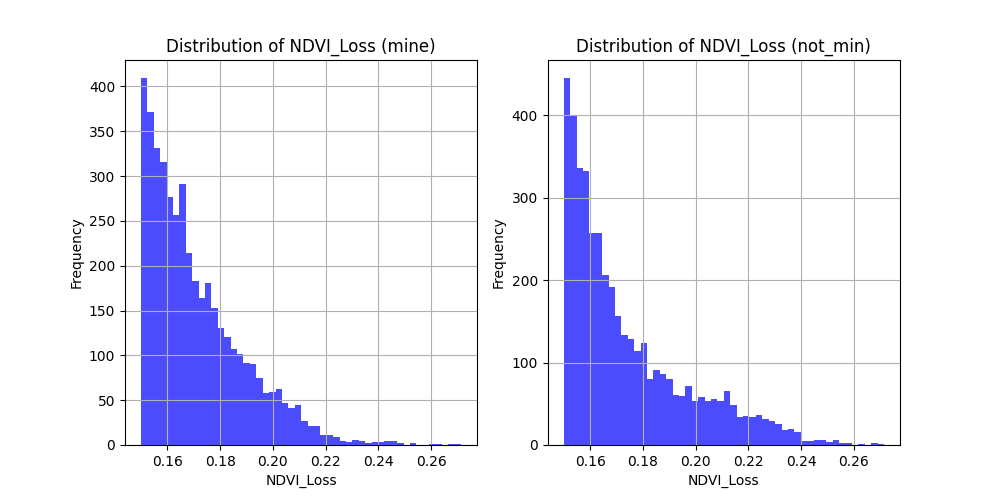

In [59]:
df1 = matched_data1.toPandas()
df0 = randomdata_0.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distribution of the column 'ndvi-loss'
ax1.hist(df1['NDVI_Loss'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of NDVI_Loss (mine)')
ax1.set_xlabel('NDVI_Loss')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'ndvi-loss'
ax2.hist(df0['NDVI_Loss'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of NDVI_Loss (not_min)')
ax2.set_xlabel('NDVI_Loss')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

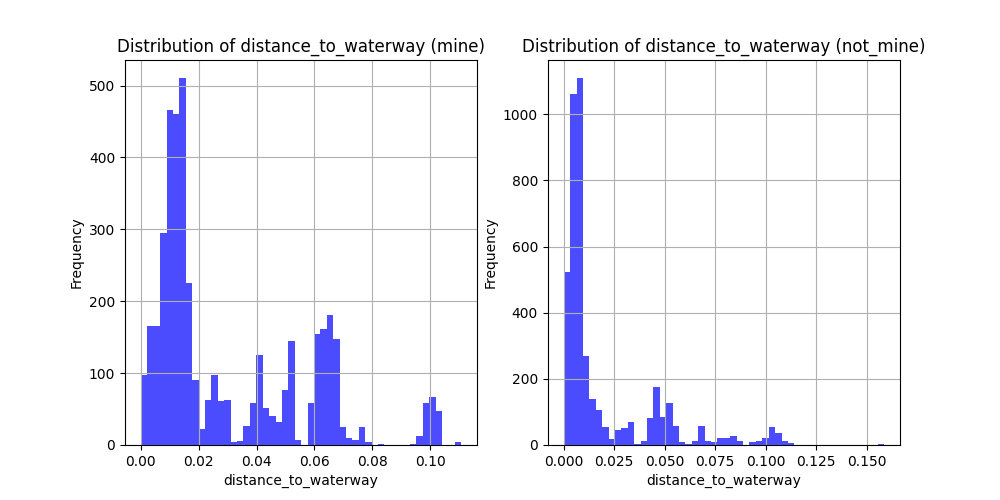

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_waterway'
ax1.hist(df1['Distance_to_Waterways'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of distance_to_waterway (mine)')
ax1.set_xlabel('distance_to_waterway')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_waterway'
ax2.hist(df0['Distance_to_Waterways'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of distance_to_waterway (not_mine)')
ax2.set_xlabel('distance_to_waterway')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

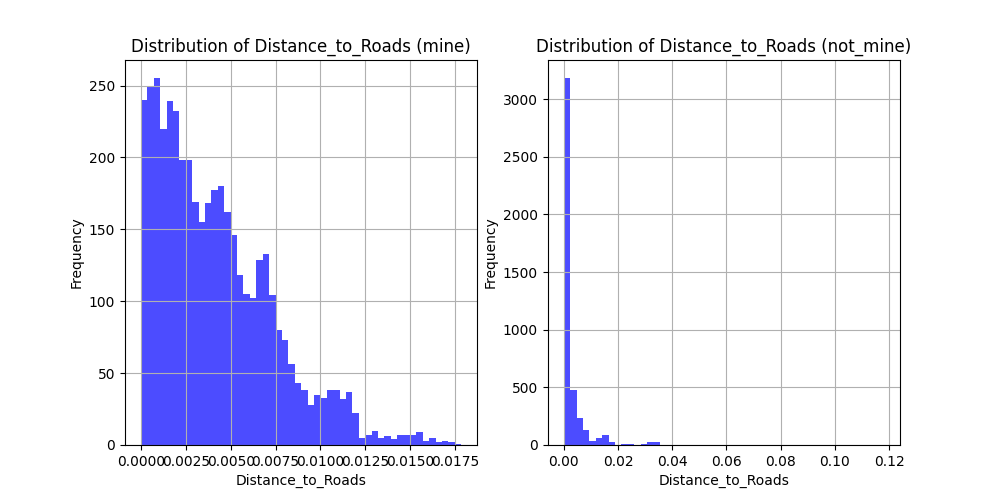

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_local_road'
ax1.hist(df1['Distance_to_Roads'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of Distance_to_Roads (mine)')
ax1.set_xlabel('Distance_to_Roads')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_local_road'
ax2.hist(df0['Distance_to_Roads'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of Distance_to_Roads (not_mine)')
ax2.set_xlabel('Distance_to_Roads')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

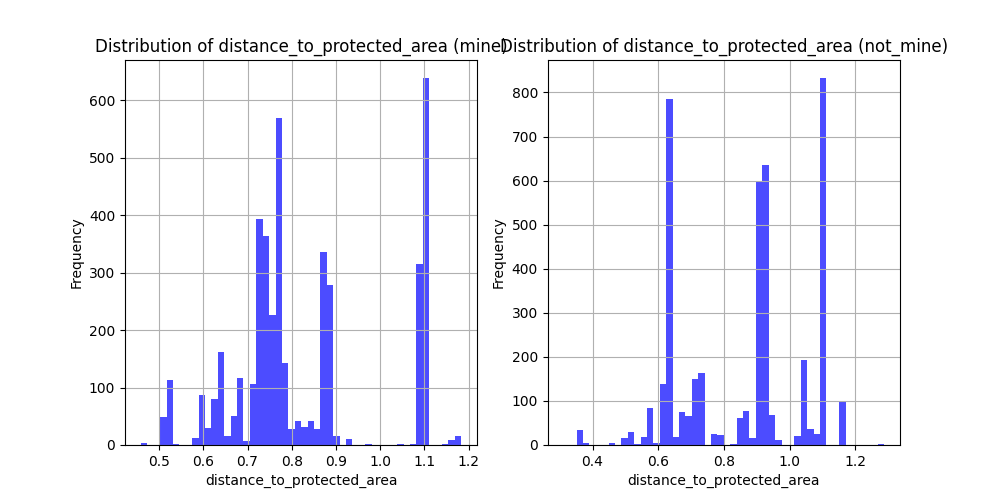

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_protected_area'
ax1.hist(df1['Distance_to_Protected_Areas_Points'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of distance_to_protected_area (mine)')
ax1.set_xlabel('distance_to_protected_area')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_protected_area'
ax2.hist(df0['Distance_to_Protected_Areas_Points'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of distance_to_protected_area (not_mine)')
ax2.set_xlabel('distance_to_protected_area')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

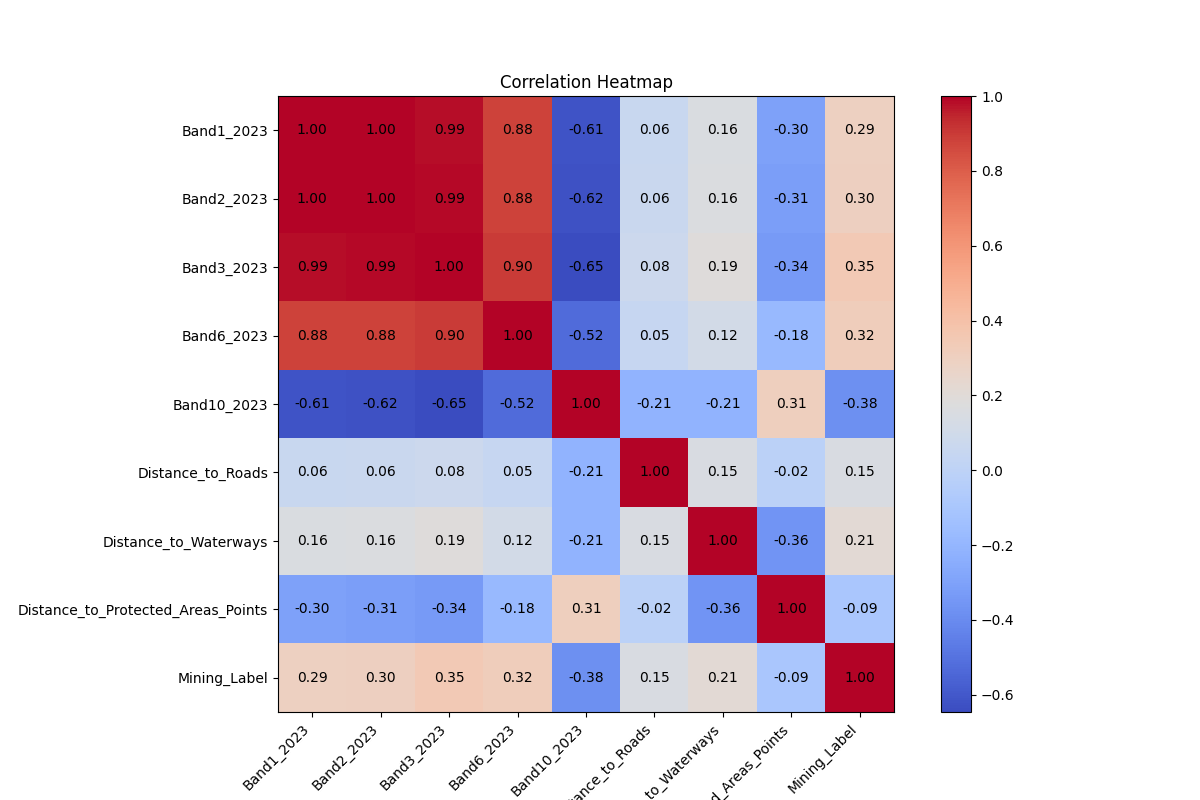

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

features = ['Band1_2023', 'Band2_2023', 'Band3_2023', 'Band6_2023', 'Band10_2023', 'Distance_to_Roads', 'Distance_to_Waterways','Distance_to_Protected_Areas_Points']

target = 'Mining_Label'

# Select the required columns
selected_columns = features + [target]
combined_data = randomdata_0.union(matched_data1)
data1 = combined_data.select(selected_columns)

# Convert to Pandas DataFrame
pandas_df = data1.toPandas()

# Compute the correlation matrix
correlation_matrix = pandas_df.corr()

# Plot the heatmap using Matplotlib
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(heatmap)

# Add labels
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

# Annotate the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title('Correlation Heatmap')


%matplot plt

## Step 2:  Data Transformations and Feature Engineering

In [64]:
## Assembler feature
features = ['Band1_2023', 'Band2_2023', 'Band3_2023', 'Band6_2023', 'Band10_2023', 'Distance_to_Roads', 'Distance_to_Waterways','Distance_to_Protected_Areas_Points']
assembler = VectorAssembler(inputCols=features, outputCol='myfeatures')

# Add a normalizer
normalizer = Normalizer(inputCol="myfeatures", outputCol="normFeatures", p=1.0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Step 3: Develop Pipelines and Employee Machine Learnig Models to Predict

In [65]:
# split into train/test data
train_1, test_1 = combined_data.randomSplit([0.7, 0.3], seed=0)

# Persist data in memory to speed up I/O during training/testing
train_1.persist()
test_1.persist()

# confirm they're cached
print(train_1.is_cached, train_1.is_cached)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

True True

## 3.1 Logit Model

### 3.1.1  Develop Pipeline using Logit Model 

In [66]:
# Define the Logit Regression model
lr = LogisticRegression(featuresCol='normFeatures', labelCol='Mining_Label')


# Create the pipeline
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            lr])
 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.1.2  Test Pipeline Performance using Combined Data

In [67]:
# Train the model
logitmodel = pipeline.fit(train_1)

# Make predictions
predictions = logitmodel.transform(test_1)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Mining_Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))

# Compute additional metrics
prediction_and_labels = predictions.select(col("prediction").cast("double"), col("Mining_Label").cast("double")).rdd.map(tuple)
metrics = MulticlassMetrics(prediction_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fn)))
print("True negative rate = {}".format(tn / (tn + fp)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.8072699734948883
Confusion Matrix:
 [[1122.  213.]
 [ 296. 1010.]]
True Positives (TP): 1010.0
True Negatives (TN): 1122.0
False Positives (FP): 213.0
False Negatives (FN): 296.0
True positive rate = 0.7733537519142419
True negative rate = 0.8404494382022472

In [68]:
## Finding Optimal Model Parameters 

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, np.arange(0, 0.1, 0.01)) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

evaluator = RegressionEvaluator(labelCol="Mining_Label", metricName="rmse")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
# Fit the model
cvModel = crossval.fit(train_1)

# Get the best model
bestModel = cvModel.bestModel
        

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
### Evaluate the Model on whole Data

predictions = bestModel.transform(test_1)
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: ", rmse)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data:  0.43901028063715286

In [85]:
# Extract feature coefficients feature 

features_coefficients = bestModel.stages[-1].coefficients
importance = dict(zip(features, features_coefficients))
sorted_importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)

print("Feature Importances:")
for feature,coeff in sorted_importance:
    print(f"{feature}: {coeff}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Feature Importances:
Distance_to_Waterways: 1315069.2255587522
Distance_to_Protected_Areas_Points: 301722.74168905395
Distance_to_Roads: 278827.4370103807
Band2_2023: -548.1009794792087
Band3_2023: 302.3392653868317
Band1_2023: 301.57129510397584
Band6_2023: -23.470915116092907
Band10_2023: -16.12671737146959

## 3.2 Random Forest 

### 3.2.1  Develop Pipeline 

In [77]:

# We can train a logistic regression classifier to predict the binary feature `Mining_Label`.

rf = RandomForestClassifier(featuresCol='normFeatures', labelCol='Mining_Label')

# Create the pipelisne
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            rf])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

###  3.2.2  Test Pipeline Performance 

In [78]:

## Evaluate random forest model usig data
rf_model = pipeline.fit(train_1)

predictions = rf_model.transform(test_1)

evaluator = MulticlassClassificationEvaluator(labelCol="Mining_Label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))


prediction_and_labels = predictions.select(col("prediction").cast("double"), col("Mining_Label").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.8553578190079515
Confusion Matrix:
 [[1200.  135.]
 [ 247. 1059.]]
True Positives (TP): 1059.0
True Negatives (TN): 1200.0
False Positives (FP): 135.0
False Negatives (FN): 247.0
True positive rate = 0.8869346733668342
True negative rate = 0.82930200414651

## 3.3 Neutral Network

### 3.3.1 Develop Pipeline

In [79]:
# Specify layers for the neural network:
# Input layer of size 8 (features), two intermediate layers of size 16 and 32,
# and output layer of size 2 (classes)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [8, 16, 32, 2]

# Create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, labelCol="Mining_Label", featuresCol="normFeatures")

# Create the pipeline
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            trainer])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.3.2  Test Pipeline Performance using combined Data

In [80]:
# Train the model using train_1 dataset
model_1 = pipeline.fit(train_1)

# Compute accuracy on the test set
result = model_1.transform(test_1)
prediction_and_labels = result.select("prediction", "Mining_Label")
evaluator = MulticlassClassificationEvaluator(labelCol="Mining_Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(result)

print(f"Test set accuracy = {accuracy}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test set accuracy = 0.7864445285876562

In [81]:
prediction_and_labels = result.select(col("prediction").cast("double"), col("Mining_Label").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix:
 [[1045.  290.]
 [ 274. 1032.]]
True Positives (TP): 1032.0
True Negatives (TN): 1045.0
False Positives (FP): 290.0
False Negatives (FN): 274.0
True positive rate = 0.7806354009077155
True negative rate = 0.7922668688400303

## 3.3 Decision Tree

In [82]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create Decision Tree model
dt = DecisionTreeClassifier(labelCol="Mining_Label", featuresCol="normFeatures", maxDepth=1)

# Create the pipelisne
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            dt])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
## Evaluate random forest model usig data
dt_model = pipeline.fit(train_1)

predictions = dt_model.transform(test_1)

evaluator = MulticlassClassificationEvaluator(labelCol="Mining_Label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))


prediction_and_labels = predictions.select(col("prediction").cast("double"), col("Mining_Label").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.7925028398333964
Confusion Matrix:
 [[1146.  189.]
 [ 359.  947.]]
True Positives (TP): 947.0
True Negatives (TN): 1146.0
False Positives (FP): 189.0
False Negatives (FN): 359.0
True positive rate = 0.8336267605633803
True negative rate = 0.7614617940199335

In [84]:

from graphviz import Source
from IPython.display import display

# Assuming decision_tree_model is your trained DecisionTreeClassificationModel
decision_tree_model = dt_model.stages[-1]
dot_data = decision_tree_model.toDebugString.replace('TreeEnsembleModel', 'DecisionTree')
dot_data = dot_data.replace('|', '\n')

# Create a Graphviz source object
graph = Source(dot_data)

# Display the tree inline
display(graph)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
No module named 'IPython'
Traceback (most recent call last):
ModuleNotFoundError: No module named 'IPython'

